In [32]:
from emulator_utils.pre_process import log_standard, minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp

In [2]:
import matplotlib.pylab as plt
import numpy as np
from glob import glob

### Reading spectra

Text(0, 0.5, 'Pk')

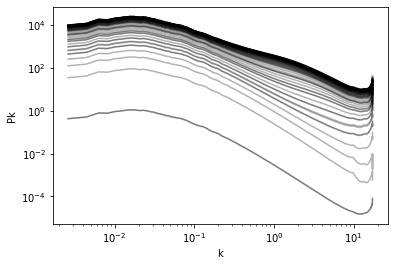

In [21]:
k, _, _, _ = readpowerspec('../test/data/powerspec_LJ/m000p.pk.499')
fnames = glob('../test/data/powerspec_LJ/*')
pk_all = np.array([readpowerspec(f)[1] for f in fnames])


plt.figure(1)
plt.plot(k, pk_all.T, 'k', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Using a pre-processing pipeline.(First log10, then a standardization)

In [22]:
scaled, scaler = log_standard(pk_all)

In [33]:
params = np.arange(scaled.shape[0]).reshape(-1, 1)
scaled_y, scaler_y = minmax(params)

### Sample neural network 

In [34]:
pk_train, pk_test, param_train, param_test = random_holdout(scaled, params, split_fraction = 0.2)

### Fixing the network architecture (hidden_dims is flexible)

In [35]:
mlp = simple_mlp(input_shape=1, output_shape=pk_train.shape[1], hidden_dims=[16, 32, 64, 512])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                32        
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 512)               33280     
                                                                 
 dense_14 (Dense)            (None, 9311)              4776543   
                                                                 
Total params: 4,812,511
Trainable params: 4,812,511
Non-trainable params: 0
_________________________________________________________________
None


### Set-up hyper-parameters

In [36]:
learning_rate = 0.01
decay_rate = 0.1
batch_size = 4
num_epochs = 10

In [37]:
mlp, train_history = train_mlp(mlp, 
                    param_train, pk_train, param_test, pk_test, 
                    learning_rate, decay_rate, batch_size, num_epochs)

1/1 [==============================] - 12s 12s/step - loss: 1.3299 - mean_squared_error: 1.3299
Test Accuracy: 1.330


In [ ]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [38]:
save_mlp(mlp, '../test/model/trained_mlp')
mlp = load_mlp('../test/model/trained_mlp')

INFO:tensorflow:Assets written to: ../test/model/trained_mlp/assets
Model saved at../test/model/trained_mlp


## explainers 

In [ ]:
## local SHAP model
## global ALE model